<a href="https://colab.research.google.com/github/ichisadashioko/dqn/blob/master/ddqn_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if False:
    !pip install tensorflow==2.0.0-beta1

In [2]:
if False:
    !pip install tensorflow-gpu==2.0.0-beta1

In [3]:
import os
import time
import math
import random
from datetime import datetime
from collections import namedtuple, deque

from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gym
from gym.envs.registration import register

In [4]:
# disable GPU (optional)
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [5]:
# disable TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam

In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity=1_000_000):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size=32):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
memory = ReplayMemory()
len(memory)

0

In [8]:
env_name = 'CartPole-v1'
env = gym.make(env_name).unwrapped

In [9]:
if False:
# if True:
    from google.colab import drive
    mount_point = '/gdrive'
    drive.mount(mount_point, force_remount=True)
    save_dir = f'{mount_point}/My Drive/DQN-{env_name}'
else:
    save_dir = f'./DQN-{env_name}'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

os.path.exists(save_dir)

True

## Hyperparameters

In [10]:
input_shape = env.observation_space.shape
n_actions = env.action_space.n
lr = 0.0001
BATCH_SIZE = 32
GAMMA = 0.99

EPS_START = 1 # initial value of epsilon
EPS_END = 0.1 # final value of epsilon
EPS_DECAY = 500_000 # number of steps until epsilon reach its final value
steps_done = 0

In [11]:
def create_network(name, input_shape, n_actions, lr, activation_name):
    model = keras.Sequential(name=name, layers=[
        Dense(
            name=f'{name}_dense_01',
            units=32,
            input_shape=input_shape,
            activation=activation_name,
        ),
        Dense(
            name=f'{name}_dense_02',
            units=64,
            activation=activation_name,
        ),
        Dense(
            name=f'{name}_dense_03',
            units=n_actions,
            activation='linear',
        )
    ])

    optimizer = RMSprop(lr=lr)

    model.compile(
        optimizer=optimizer,
        loss='mse',
    )

    return model

In [12]:
activation_name = 'relu'

target_net = create_network(
    name='target_net',
    input_shape=input_shape,
    n_actions=n_actions,
    lr=lr,
    activation_name=activation_name,
)

target_net.summary()

policy_net = create_network(
    name='policy_net',
    input_shape=input_shape,
    n_actions=n_actions,
    lr=lr,
    activation_name=activation_name,
)

policy_net.summary()

Model: "target_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
target_net_dense_01 (Dense)  (None, 32)                160       
_________________________________________________________________
target_net_dense_02 (Dense)  (None, 64)                2112      
_________________________________________________________________
target_net_dense_03 (Dense)  (None, 2)                 130       
Total params: 2,402
Trainable params: 2,402
Non-trainable params: 0
_________________________________________________________________
Model: "policy_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
policy_net_dense_01 (Dense)  (None, 32)                160       
_________________________________________________________________
policy_net_dense_02 (Dense)  (None, 64)                2112      
__________________________________

Copy weights from target network to policy network

In [13]:
policy_net.set_weights(target_net.get_weights())

In [14]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    if sample > eps_threshold:
        batch = np.array([state])
        action = np.argmax(policy_net.predict(batch)[0])
    else:
        action = random.randrange(n_actions)
    
    steps_done += 1
    return action

In [15]:
class MyClassback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.log = []

    def on_epoch_end(self, epoch, logs={}):
        self.log.append(logs)

In [16]:
callback = MyClassback()

In [17]:
optimize_model_time = []
process_data_time = []
predict_time = []
fit_time = []

In [18]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    optimize_start = time.time()
    transitions = memory.sample(BATCH_SIZE)
    # transpose the batch
    batch = Transition(*zip(*transitions))
    
    s = np.array(batch.state)
    a = np.array(batch.action)
    r = np.array(batch.reward)
    
    non_final_mask = np.array(list(map(lambda s: s is not None, batch.next_state)))
    non_final_s2 = np.array([s for s in batch.next_state if s is not None])

    forward_batch = np.concatenate((s, non_final_s2), axis=0)
    _proc_time = time.time() - optimize_start
    process_data_time.append(_proc_time)

    _predict_start = time.time()
    forward_values = target_net.predict(forward_batch)
    # compute V(s_{t+1}) for all next states (except for terminal states)
    # s2_values = agent_net.predict(non_final_s2)
    s2_values = forward_values[len(s):]
    # compute old Q-values
    # s_values = agent_net.predict(s)
    s_values = forward_values[:len(s)]
    _predict_time = time.time() - _predict_start
    predict_time.append(_predict_time)
    
#     target_q = np.zeros((BATCH_SIZE, n_actions), dtype=np.float32)
    target_q = s_values
    s2_index = 0
    for i in range(BATCH_SIZE):
        if non_final_mask[i]:
            target_q[i][a[i]] = np.max(s2_values[s2_index]) * GAMMA + r[i]
            s2_index += 1
        else:
            # subject to change
            target_q[i][a[i]] = r[i]
    
    _fit_start = time.time()
    policy_net.fit(
        x=s,
        y=target_q,
        verbose=0,
        callbacks=[callback]
    )
    _fit_time = time.time() - _fit_start
    fit_time.append(_fit_time)
    
    optimize_model_time.append(time.time() - optimize_start)

In [19]:
def evaluate_networks(num_episodes=20, show=False, max_steps=1_000):
    # use random as baseline
    rand_reward_log = []
    rand_action_log = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        ep_action_log = []
        for _ in range(max_steps):
            action = random.randrange(env.action_space.n)
            ep_action_log.append(action)
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            state = next_state
            if done:
                break
        rand_reward_log.append(total_reward)
        rand_action_log.append(ep_action_log)
    rand_reward_log = np.array(rand_reward_log)
    rand_reward_mean = np.mean(rand_reward_log)
    rand_reward_max = np.max(rand_reward_log)
    rand_reward_min = np.min(rand_reward_log)
    
    print()
    print(f'Random Mean: {rand_reward_mean}')
    print(f'Random Max: {rand_reward_max}')
    print(f'Random Min: {rand_reward_min}')
    
    if show:
        rand_mean_plot = np.zeros_like(rand_reward_log)
        rand_mean_plot.fill(rand_reward_mean)
        plt.plot(rand_reward_log)
        plt.plot(rand_mean_plot)
        plt.show()

    # evaluate agent (before update)
    target_reward_log = []
    target_action_log = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        ep_action_log = []
        for _ in range(max_steps):
            action = np.argmax(target_net.predict(np.array([state]))[0])
            ep_action_log.append(action)
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            state = next_state
            if done:
                break
        target_reward_log.append(total_reward)
        target_action_log.append(ep_action_log)
    target_reward_log = np.array(target_reward_log)
    target_reward_mean = np.mean(target_reward_log)
    target_reward_max = np.max(target_reward_log)
    target_reward_min = np.min(target_reward_log)
    
    print()
    print(f'Target Mean: {target_reward_mean} {(target_reward_mean/rand_reward_mean)*100:.2f}% compare to random')
    print(f'Target Max: {target_reward_max} {(target_reward_max/rand_reward_max)*100:.2f}% compare to random')
    print(f'Target Min: {target_reward_min} {(target_reward_min/rand_reward_min)*100:.2f}% compare to random')
    
    if show:
        target_mean_plot = np.zeros_like(target_reward_log)
        target_mean_plot.fill(target_reward_mean)
        plt.plot(target_reward_log)
        plt.plot(target_mean_plot)
        plt.show()


    # evaluate agent (after update)
    policy_reward_log = []
    policy_action_log = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        ep_action_log = []
        for _ in range(max_steps):
            action = np.argmax(policy_net.predict(np.array([state]))[0])
            ep_action_log.append(action)
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            state = next_state
            if done:
                break
        policy_reward_log.append(total_reward)
        policy_action_log.append(ep_action_log)
    policy_reward_log = np.array(policy_reward_log)
    policy_reward_mean = np.mean(policy_reward_log)
    policy_reward_max = np.max(policy_reward_log)
    policy_reward_min = np.min(policy_reward_log)
    
    print()
    print(f'Policy Mean: {policy_reward_mean} {(policy_reward_mean/rand_reward_mean)*100:.2f}% compare to random')
    print(f'Policy Max: {policy_reward_max} {(policy_reward_max/rand_reward_max)*100:.2f}% compare to random')
    print(f'Policy Min: {policy_reward_min} {(policy_reward_min/rand_reward_min)*100:.2f}% compare to random')
    
    if show:
        policy_mean_plot = np.zeros_like(policy_reward_log)
        policy_mean_plot.fill(policy_reward_mean)
        plt.plot(policy_reward_log)
        plt.plot(policy_mean_plot)
        plt.show()

## Training loop

In [20]:
train_reward_log = []

  5%|███▋                                                                      | 19997/400000 [01:05<19:47, 320.07it/s]


Random Mean: 18.1
Random Max: 38.0
Random Min: 9.0

Target Mean: 11.4 62.98% compare to random
Target Max: 28.0 73.68% compare to random
Target Min: 8.0 88.89% compare to random

Policy Mean: 17.45 96.41% compare to random
Policy Max: 24.0 63.16% compare to random
Policy Min: 14.0 155.56% compare to random


c:\users\shioko\appdata\local\programs\python\python37\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
 10%|███████▍                                                                  | 39985/400000 [02:11<19:58, 300.34it/s]


Random Mean: 27.25
Random Max: 84.0
Random Min: 10.0

Target Mean: 16.75 61.47% compare to random
Target Max: 23.0 27.38% compare to random
Target Min: 10.0 100.00% compare to random

Policy Mean: 10.25 37.61% compare to random
Policy Max: 13.0 15.48% compare to random
Policy Min: 9.0 90.00% compare to random


 15%|███████████                                                               | 59977/400000 [03:21<20:57, 270.33it/s]


Random Mean: 24.75
Random Max: 71.0
Random Min: 12.0

Target Mean: 10.35 41.82% compare to random
Target Max: 12.0 16.90% compare to random
Target Min: 9.0 75.00% compare to random

Policy Mean: 9.5 38.38% compare to random
Policy Max: 11.0 15.49% compare to random
Policy Min: 8.0 66.67% compare to random


 20%|██████████████▊                                                           | 79973/400000 [04:28<18:12, 292.89it/s]


Random Mean: 21.95
Random Max: 45.0
Random Min: 10.0

Target Mean: 9.2 41.91% compare to random
Target Max: 11.0 24.44% compare to random
Target Min: 8.0 80.00% compare to random

Policy Mean: 9.95 45.33% compare to random
Policy Max: 12.0 26.67% compare to random
Policy Min: 9.0 90.00% compare to random


 25%|██████████████████▍                                                       | 99978/400000 [05:35<16:08, 309.75it/s]


Random Mean: 20.25
Random Max: 63.0
Random Min: 9.0

Target Mean: 9.8 48.40% compare to random
Target Max: 12.0 19.05% compare to random
Target Min: 9.0 100.00% compare to random

Policy Mean: 9.7 47.90% compare to random
Policy Max: 11.0 17.46% compare to random
Policy Min: 8.0 88.89% compare to random


 30%|█████████████████████▉                                                   | 119983/400000 [06:40<15:07, 308.50it/s]


Random Mean: 23.15
Random Max: 70.0
Random Min: 9.0

Target Mean: 9.6 41.47% compare to random
Target Max: 11.0 15.71% compare to random
Target Min: 8.0 88.89% compare to random

Policy Mean: 9.7 41.90% compare to random
Policy Max: 11.0 15.71% compare to random
Policy Min: 9.0 100.00% compare to random


 35%|█████████████████████████▌                                               | 139978/400000 [07:49<14:43, 294.47it/s]


Random Mean: 22.15
Random Max: 39.0
Random Min: 10.0

Target Mean: 9.75 44.02% compare to random
Target Max: 11.0 28.21% compare to random
Target Min: 9.0 90.00% compare to random

Policy Mean: 13.45 60.72% compare to random
Policy Max: 26.0 66.67% compare to random
Policy Min: 10.0 100.00% compare to random


 40%|█████████████████████████████▏                                           | 159989/400000 [09:03<14:54, 268.44it/s]


Random Mean: 27.15
Random Max: 84.0
Random Min: 11.0

Target Mean: 10.95 40.33% compare to random
Target Max: 25.0 29.76% compare to random
Target Min: 9.0 81.82% compare to random

Policy Mean: 15.5 57.09% compare to random
Policy Max: 26.0 30.95% compare to random
Policy Min: 10.0 90.91% compare to random


 45%|████████████████████████████████▊                                        | 179998/400000 [10:18<13:44, 266.85it/s]


Random Mean: 23.1
Random Max: 40.0
Random Min: 10.0

Target Mean: 17.55 75.97% compare to random
Target Max: 28.0 70.00% compare to random
Target Min: 10.0 100.00% compare to random

Policy Mean: 26.25 113.64% compare to random
Policy Max: 39.0 97.50% compare to random
Policy Min: 22.0 220.00% compare to random


 50%|████████████████████████████████████▍                                    | 199985/400000 [11:38<14:06, 236.33it/s]


Random Mean: 21.25
Random Max: 43.0
Random Min: 10.0

Target Mean: 25.65 120.71% compare to random
Target Max: 29.0 67.44% compare to random
Target Min: 23.0 230.00% compare to random

Policy Mean: 64.55 303.76% compare to random
Policy Max: 154.0 358.14% compare to random
Policy Min: 26.0 260.00% compare to random


 55%|████████████████████████████████████████▏                                | 219984/400000 [13:00<12:11, 245.96it/s]


Random Mean: 23.8
Random Max: 49.0
Random Min: 9.0

Target Mean: 66.5 279.41% compare to random
Target Max: 178.0 363.27% compare to random
Target Min: 25.0 277.78% compare to random

Policy Mean: 116.45 489.29% compare to random
Policy Max: 230.0 469.39% compare to random
Policy Min: 24.0 266.67% compare to random


 60%|███████████████████████████████████████████▊                             | 240000/400000 [14:23<11:32, 231.07it/s]


Random Mean: 22.85
Random Max: 50.0
Random Min: 9.0

Target Mean: 123.85 542.01% compare to random
Target Max: 212.0 424.00% compare to random
Target Min: 52.0 577.78% compare to random

Policy Mean: 131.0 573.30% compare to random
Policy Max: 182.0 364.00% compare to random
Policy Min: 58.0 644.44% compare to random


 65%|███████████████████████████████████████████████▍                         | 259977/400000 [15:50<09:20, 249.88it/s]


Random Mean: 30.35
Random Max: 84.0
Random Min: 11.0

Target Mean: 135.85 447.61% compare to random
Target Max: 171.0 203.57% compare to random
Target Min: 42.0 381.82% compare to random

Policy Mean: 136.6 450.08% compare to random
Policy Max: 186.0 221.43% compare to random
Policy Min: 43.0 390.91% compare to random


 70%|███████████████████████████████████████████████████                      | 279984/400000 [17:14<08:25, 237.33it/s]


Random Mean: 21.35
Random Max: 40.0
Random Min: 9.0

Target Mean: 140.25 656.91% compare to random
Target Max: 185.0 462.50% compare to random
Target Min: 68.0 755.56% compare to random

Policy Mean: 200.3 938.17% compare to random
Policy Max: 363.0 907.50% compare to random
Policy Min: 105.0 1166.67% compare to random


 75%|██████████████████████████████████████████████████████▋                  | 299988/400000 [18:35<06:19, 263.62it/s]


Random Mean: 27.3
Random Max: 60.0
Random Min: 14.0

Target Mean: 188.55 690.66% compare to random
Target Max: 312.0 520.00% compare to random
Target Min: 105.0 750.00% compare to random

Policy Mean: 227.75 834.25% compare to random
Policy Max: 535.0 891.67% compare to random
Policy Min: 125.0 892.86% compare to random


 80%|██████████████████████████████████████████████████████████▍              | 320000/400000 [19:57<05:04, 262.75it/s]


Random Mean: 17.75
Random Max: 37.0
Random Min: 9.0

Target Mean: 221.15 1245.92% compare to random
Target Max: 329.0 889.19% compare to random
Target Min: 127.0 1411.11% compare to random

Policy Mean: 202.6 1141.41% compare to random
Policy Max: 300.0 810.81% compare to random
Policy Min: 148.0 1644.44% compare to random


 85%|██████████████████████████████████████████████████████████████           | 339989/400000 [21:21<03:50, 260.82it/s]


Random Mean: 24.4
Random Max: 49.0
Random Min: 9.0

Target Mean: 185.85 761.68% compare to random
Target Max: 247.0 504.08% compare to random
Target Min: 136.0 1511.11% compare to random

Policy Mean: 200.3 820.90% compare to random
Policy Max: 333.0 679.59% compare to random
Policy Min: 169.0 1877.78% compare to random


 90%|█████████████████████████████████████████████████████████████████▋       | 359997/400000 [22:45<02:43, 245.15it/s]


Random Mean: 23.2
Random Max: 45.0
Random Min: 10.0

Target Mean: 206.9 891.81% compare to random
Target Max: 272.0 604.44% compare to random
Target Min: 154.0 1540.00% compare to random

Policy Mean: 280.0 1206.90% compare to random
Policy Max: 377.0 837.78% compare to random
Policy Min: 179.0 1790.00% compare to random


 95%|█████████████████████████████████████████████████████████████████████▎   | 379997/400000 [24:12<01:21, 244.85it/s]


Random Mean: 20.85
Random Max: 39.0
Random Min: 12.0

Target Mean: 279.15 1338.85% compare to random
Target Max: 445.0 1141.03% compare to random
Target Min: 153.0 1275.00% compare to random

Policy Mean: 266.05 1276.02% compare to random
Policy Max: 374.0 958.97% compare to random
Policy Min: 178.0 1483.33% compare to random


100%|█████████████████████████████████████████████████████████████████████████| 400000/400000 [25:43<00:00, 259.21it/s]



Mean: 26.03
Max: 318.0
Min: 1.0


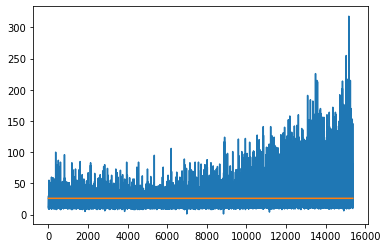

In [21]:
scale = 10_000
update_freq = 2 * scale
save_freq = 4 * scale

num_steps = save_freq * 10

episode_count = 0
state = env.reset()
ep_reward = 0

for step_num in tqdm(range(num_steps)):
    action = select_action(state) # select action use epsilon-greedy
    # the agent is seem to perform better when training with random data (the first 500_000 steps only)
    # action = random.randrange(n_actions)
    next_state, reward, done, info = env.step(action)
    ep_reward += reward
    
    if done:
        next_state = None
    memory.push(state, action, next_state, reward)
    
    if done:
        train_reward_log.append(ep_reward)
        ep_reward = 0
        episode_count += 1
        state = env.reset()
    else:
        state = next_state
    
    optimize_model()
    
    if step_num > 0:
        if step_num % update_freq == 0:
            evaluate_networks()
            target_net.set_weights(policy_net.get_weights())
        if step_num % save_freq == 0:
            timestr = time.strftime('%Y%m%d-%H%M%S')
            fname = f'{save_dir}/weights_{timestr}_{activation_name}_{steps_done}.h5'
            target_net.save_weights(fname)

timestr = time.strftime('%Y%m%d-%H%M%S')
fname = f'{save_dir}/model_{timestr}_{activation_name}_{steps_done}.h5'
target_net.save(fname)

np_reward = np.array(train_reward_log[-episode_count:])

reward_mean = np.mean(np_reward)
reward_max = np.max(np_reward)
reward_min = np.min(np_reward)

print()
print(f'Mean: {reward_mean:.2f}')
print(f'Max: {reward_max}')
print(f'Min: {reward_min}')

mean_plot = np.zeros_like(np_reward)
mean_plot.fill(reward_mean)

plt.plot(np_reward)
plt.plot(mean_plot)

## Replay memory only

In [22]:
# scale = 2_000
# update_freq = scale * 2
# save_freq = scale * 4

# num_steps = save_freq * 4

# for step_num in tqdm(range(num_steps)):
#     optimize_model()

#     if step_num > 0:
#         if step_num % update_freq == 0:
#             evaluate_networks()
#             target_net.set_weights(policy_net.get_weights())
#         if step_num % save_freq == 0:
#             timestr = time.strftime('%Y%m%d-%H%M%S')
#             fname = f'{save_dir}/weights_{timestr}_{activation_name}_{steps_done}.h5'
#             target_net.save_weights(fname)


Random Mean: 23.62
Random Max: 76.0
Random Min: 9.0


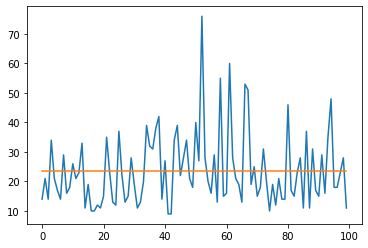


Target Mean: 283.37 1199.70% compare to random
Target Max: 422.0 555.26% compare to random
Target Min: 185.0 2055.56% compare to random


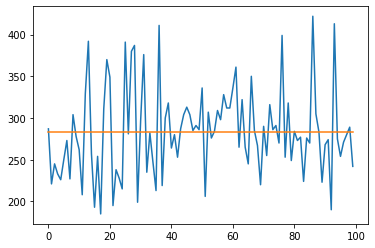


Policy Mean: 252.79 1070.24% compare to random
Policy Max: 401.0 527.63% compare to random
Policy Min: 180.0 2000.00% compare to random


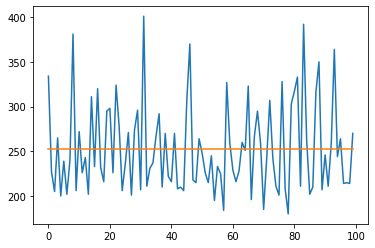

In [29]:
evaluate_networks(
    num_episodes=100, 
    show=True,
)

## Plot time data

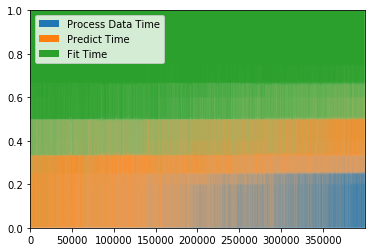

In [30]:
# reference https://python-graph-gallery.com/255-percentage-stacked-area-chart/

time_data = pd.DataFrame({
    'process_time': process_data_time,
    'predict_time': predict_time,
    'fit_time': fit_time,
})

# We need to transform the data from raw data to percentage (fraction)
time_data_perc = time_data.divide(time_data.sum(axis=1), axis=0)

# make the plot
plt.stackplot(
    range(len(time_data_perc)),
    time_data_perc['process_time'],
    time_data_perc['predict_time'],
    time_data_perc['fit_time'],
    labels=['Process Data Time', 'Predict Time', 'Fit Time'],
)
plt.legend(loc='upper left')
plt.margins(0, 0)
plt.show()

In [31]:
len(memory)

400000

In [25]:
callback.log[:10]

[{'loss': 0.5511572360992432},
 {'loss': 0.5434291362762451},
 {'loss': 0.5420385599136353},
 {'loss': 0.5408966541290283},
 {'loss': 0.5293301343917847},
 {'loss': 0.5304077863693237},
 {'loss': 0.5338785648345947},
 {'loss': 0.5323253870010376},
 {'loss': 0.5384925603866577},
 {'loss': 0.5246586203575134}]

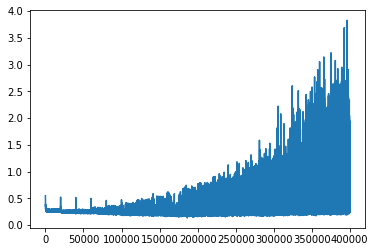

In [32]:
loss_log = [x['loss'] for x in callback.log]
plt.plot(loss_log)

Populate memory for testing if you haven't start training loop.

In [27]:
# state = env.reset()
# reward = 0
# for _ in tqdm(range(100_000)):
#     action = random.randrange(n_actions)
#     next_state, reward, done, info = env.step(action)
#     if done:
#         next_state = None
#     memory.push(state, action, next_state, reward)
#     if done:
#         state = env.reset()
#     else:
#         state = next_state

## Evaluate target network

Use random as baseline

## Evaluate using Q-value


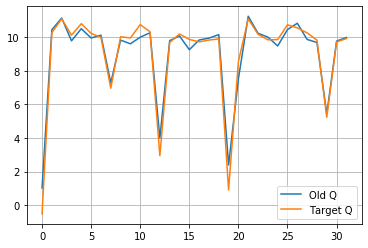

In [34]:
transitions = memory.sample(BATCH_SIZE)
# transpose the batch
batch = Transition(*zip(*transitions))

s = np.array(batch.state)
a = np.array(batch.action)
r = np.array(batch.reward)

non_final_mask = np.array(list(map(lambda s: s is not None, batch.next_state)))
non_final_s2 = np.array([s for s in batch.next_state if s is not None])

# compute V(s_{t+1}) for all next states (except for terminal states)
s2_values = target_net.predict(non_final_s2)
target_q = np.zeros((BATCH_SIZE, n_actions), dtype=np.float32)

# DEBUG
s_q = target_net.predict(s)
_old_q = []
_target_q = []
# END_DEBUG

s2_index = 0
for i in range(BATCH_SIZE):
    if non_final_mask[i]:
        target_q[i][a[i]] = np.max(s2_values[s2_index]) * GAMMA + r[i]
        # DEBUG
        _old_q.append(s_q[i][a[i]])
#         _target_q.append(target_q[i][a[i]])
        _target_q.append(np.max(s2_values[s2_index]))
        # END_DEBUG
        s2_index += 1
    else:
        # DEBUG
        _old_q.append(s_q[i][a[i]])
        _target_q.append(0)
        # END_DEBUG
_old_q = np.array(_old_q)
_target_q = np.array(_target_q)

plt.plot(_old_q, label='Old Q')
plt.plot(_target_q, label='Target Q')
plt.legend()
plt.grid()
plt.show()